In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette("tab10", 8))
%config Completer.use_jedi = False

In [29]:
def simulate_dice_throws(dice_n_faces=6, max_n_simultaneous_throws=6, n_simulations = 100000):
    
    '''
    Simulates dice throws.
    
    Param:
        - dice_n_faces: if it's a int, assume number indicates dice faces from 1 to dice_n_faces. 
    If it's a list, it indicates the values of the different faces
    
    '''
    if isinstance(dice_n_faces,list):
        simulated_throws= np.random.choice(dice_n_faces, size=(n_simulations,max_n_simultaneous_throws), replace=True)
    else:
        simulated_throws = np.random.randint(low = 1, high = dice_n_faces+1, 
                                                 size=(n_simulations,max_n_simultaneous_throws))
    
    throws = pd.DataFrame(simulated_throws)

    return throws

def prob_at_least_1_higher_than(throws, 
                                dice_n_faces=6, 
                                max_n_simultaneous_throws=6,                               
                                greater = False,
                               plot_it = False):
    '''
    Given a series of dice throws with varying number of simultaneous throws, the function estimates probability 
    that at least 1 die has value >= than a given threshold. Each die has dice_n_faces, with values going from 1 to dice_n_faces.
    
    - If greater = True, then it estimates probability that value > given threshold
    
    '''
    n_simulations = len(throws)
    my_probs ={}
    final_results = pd.DataFrame()
    aggregated_results = []
    empty_col = np.full((n_simulations, 1), False)

    if isinstance(dice_n_faces, list):
        max_threshold = max(dice_n_faces)+1
        dice_des = 'custom d' + str(len(dice_n_faces)) + ' with values ' + str(dice_n_faces)
    else:
        max_threshold = dice_n_faces+1
        dice_des = 'regular d'+ str(dice_n_faces)
        
    for i_n_simultaneous_throws in np.arange(1,max_n_simultaneous_throws+1):
        for i_threshold in np.arange(1,max_threshold):
            temp_results = {}

            if greater:
                tt = throws > i_threshold
                my_cond = '>'
            else:
                tt = throws >= i_threshold
                my_cond = '>='
                
            tt['results'] = empty_col

            for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
                tt['results'] = tt[i_throw_n] | tt['results']

            my_prob = sum(tt['results'])/len(tt['results'])

            temp_results['dice_n'] = i_n_simultaneous_throws
            temp_results['i_threshold'] = i_threshold
            temp_results['prob'] = my_prob

            aggregated_results.append(temp_results)
            
    results_df = pd.DataFrame(aggregated_results)
    
    if plot_it:
        ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
        plt.grid()
        plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
        plot_title = 'P of rolling at least 1 die ' + my_cond +' i_threshold, depending on n dice rolled'
        plot_title = plot_title + '\n(using '+ dice_des +')'
        plt.title(plot_title)
        
    return results_df


def prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=6, 
                                max_n_simultaneous_throws=6,                               
                                greater = False,
                                number_X_repeated_actual_threshold = 1,
                                loss_number_repeated = [0],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [0],
                                win_number_repeated_threshold = 2,
                               plot_it = False):
    '''
    Given a series of dice throws with varying number of simultaneous throws, the function estimates probability 
    that at least X dice have value >= than a given threshold. Each die has dice_n_faces, with values going from 1 to dice_n_faces.
    
    Parameters:
    
    - dice_n_faces: int or list. If int, it assumes max_threshold = max(dice_n_faces)+1
    
    - max_n_simultaneous_throws: int. Maximum number of simultaneous throws
    
    - number_X_repeated_actual_threshold: int. Number of dice that need to be equal or greater than threshold
    
    - greater: Boolean. If greater = True, then it estimates probability that value > given threshold. 
    If greater = False, estimates prob that value >= threshold.
    
    - loss_number_repeated: list. Dice values that can trigger an automated loss. NB: automated win trumps automatic loss.
    
    - loss_number_repeated_threshold: int. Number of values (from list loss_number_repeated) that need to appear to trigger automatic loss
    
    - win_number_repeated: list. same as for loss
    
    - win_number_repeated_threshold: int. same as for loss
    
    - plot_it: Boolean. If true, creates plot
    
    
    '''
    n_simulations = len(throws)
    my_probs ={}
    final_results = pd.DataFrame()
    aggregated_results = []
    empty_col = np.full((n_simulations, 1), False)

    if isinstance(dice_n_faces, list):
        max_threshold = max(dice_n_faces)+1
        dice_des = 'custom d' + str(len(dice_n_faces)) + ' with values ' + str(dice_n_faces)
    else:
        max_threshold = dice_n_faces+1
        dice_des = 'regular d'+ str(dice_n_faces)
    
    no_additional_rule_used = True
    
    for i_n_simultaneous_throws in np.arange(1,max_n_simultaneous_throws+1):
        for i_threshold in np.arange(1,max_threshold):
            temp_results = {}

            if greater:
                tt = throws > i_threshold
                my_cond = '>'
            else:
                tt = throws >= i_threshold
                my_cond = '>='
                
            tt = tt.astype(int)
            
            # tt_2 is equal to 1 when the loss_number_repeated appears, 0 otherwise
            tt_2 = throws.isin(loss_number_repeated)
            tt_2 = tt_2.astype(int)
            
            # tt_3 is equal to 1 when the win_number_repeated appears, 0 otherwise
            tt_3 = throws.isin( win_number_repeated)
            tt_3 = tt_3.astype(int)
            
            tt['temp_results'] = empty_col
            tt_2['temp_results'] = empty_col
            tt_3['temp_results'] = empty_col

            for i_throw_n in np.arange(0, i_n_simultaneous_throws): 
                
                # we just need one die to satisfy the first coniditon
                tt['temp_results'] = tt[i_throw_n] + tt['temp_results']
                
                # summing all the 1s and 0s for the loss condition
                tt_2['temp_results'] = tt_2[i_throw_n] + tt_2['temp_results']
            
                # summing all the 1s and 0s for the win condition
                tt_3['temp_results'] = tt_3[i_throw_n] + tt_3['temp_results']
            
            # True means no loss condition triggered. False means loss condition triggered
            tt['final_results'] = tt['temp_results'] >= number_X_repeated_actual_threshold
            
            # True means no loss condition triggered. False means loss condition triggered
            tt_2['final_results'] = tt_2['temp_results'] < loss_number_repeated_threshold
            
            # True means no win condition triggered. False means win condition triggered
            tt_3['final_results'] = tt_3['temp_results'] < win_number_repeated_threshold
            
            # if loss condition satisfied, we lose regardless of the original conidtion
            final_results_for_iteration = tt['final_results'] & tt_2['final_results']
            
            # if win conidition satisfied, we win regardless of anything else.
            final_results_for_iteration = final_results_for_iteration | np.logical_not(tt_3['final_results'] )

            no_additional_rule_used = no_additional_rule_used & final_results_for_iteration.equals(tt['final_results'])
            
            my_prob = sum(final_results_for_iteration)/len(tt['final_results'])

            temp_results['dice_n'] = i_n_simultaneous_throws
            temp_results['i_threshold'] = i_threshold
            temp_results['prob'] = my_prob

            aggregated_results.append(temp_results)
            
    results_df = pd.DataFrame(aggregated_results)
    
    if plot_it:
        ax = sns.barplot(x="i_threshold", y="prob", hue="dice_n", data=results_df)
        plt.grid()
        plt.legend(loc=(1.04,0), title="n dice rolled simultaneously")
        plot_title = 'P of rolling at least ' + str(number_X_repeated_actual_threshold) + ' dice ' + my_cond +' i_threshold, depending on n dice rolled'
        plot_title = plot_title + '\nusing '+ dice_des +''
        
        if no_additional_rule_used:
            plot_title = plot_title + '\n No conditions on repetition'
        else:
            
            plot_title = plot_title + '\n Additional conditions:'
            plot_title = plot_title + '\nLoss if ' +str(loss_number_repeated) + ' appears at least ' + str(loss_number_repeated_threshold) + 'times'
            plot_title = plot_title + '\nWin if ' +str(win_number_repeated) + ' appears at least ' + str(win_number_repeated_threshold) + 'times'
            
        plt.title(plot_title)
        
    return results_df

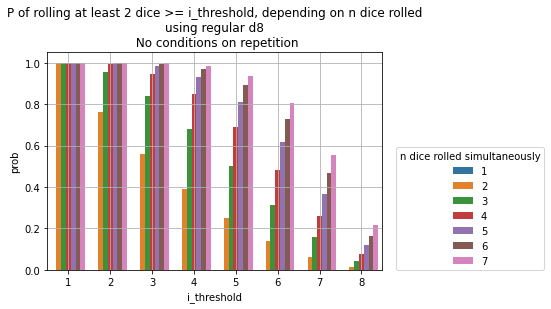

In [30]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                number_X_repeated_actual_threshold =2,
                                loss_number_repeated = [-1,-2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [-7,-8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

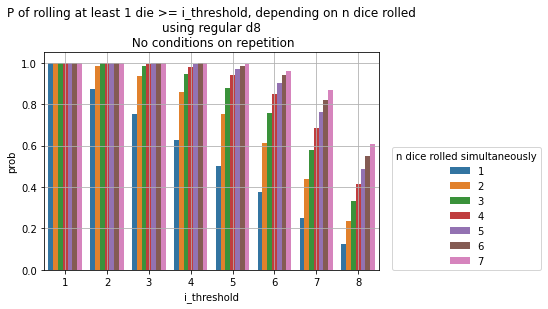

In [5]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [-1,-2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [-7,-8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

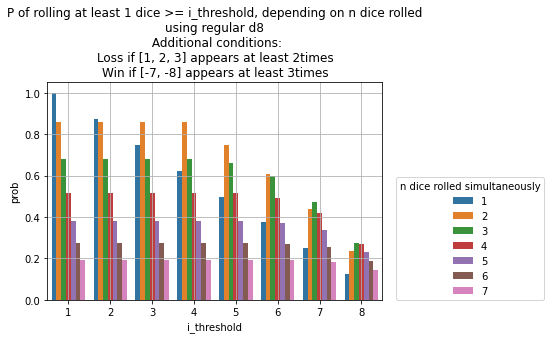

In [31]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1,2,3],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [-7,-8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

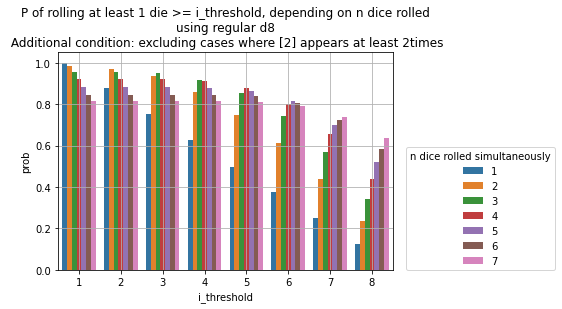

In [9]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

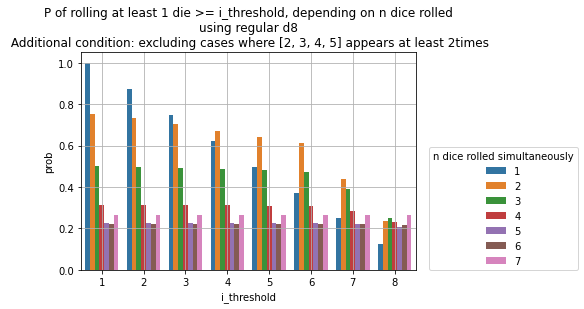

In [10]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [2,3,4,5],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

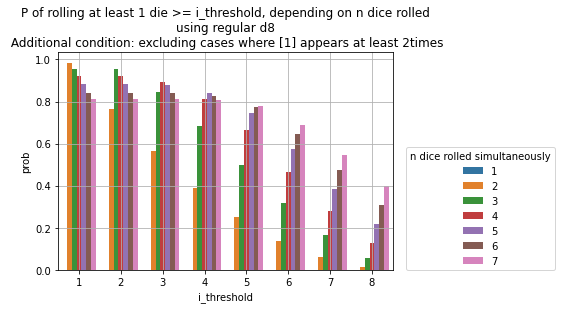

In [23]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                number_X_repeated_actual_threshold = 2,
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7],
                                win_number_repeated_threshold = 3,
                               plot_it = True)



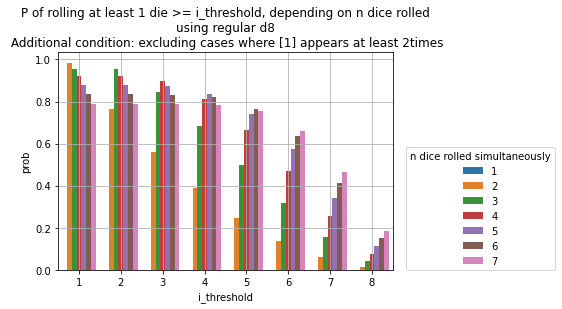

In [22]:
dice_n_faces=8
max_n_simultaneous_throws = 7


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                number_X_repeated_actual_threshold = 2,
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [-6,-7],
                                win_number_repeated_threshold = 3,
                               plot_it = True)



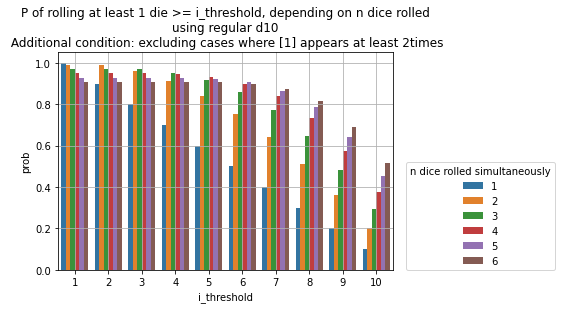

In [302]:
dice_n_faces=10
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [9,10],
                                win_number_repeated_threshold = 2,
                               plot_it = True)

In [ ]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [2,3],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

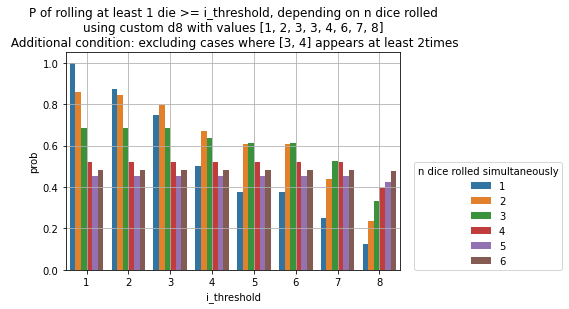

In [314]:
dice_n_faces=[1,2,3,3,4,6,7,8]
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [3,4],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [1,2,6],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

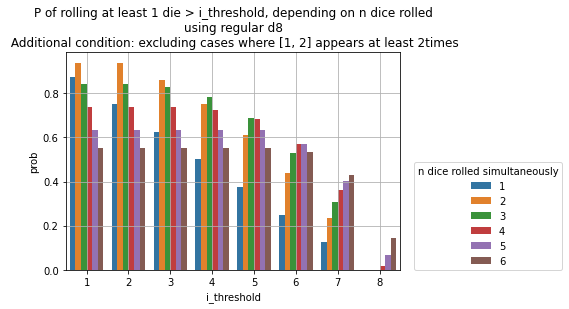

In [309]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = True,
                                loss_number_repeated = [1,2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [3,4,5],
                                win_number_repeated_threshold = 4,
                               plot_it = True)

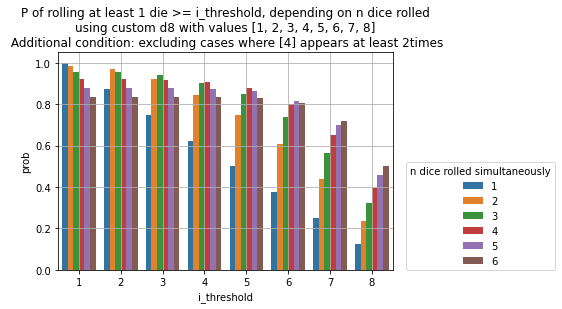

In [315]:
dice_n_faces=[1,2,3,4,5,6,7,8]
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [4],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [2,3],
                                win_number_repeated_threshold = 4,
                               plot_it = True)

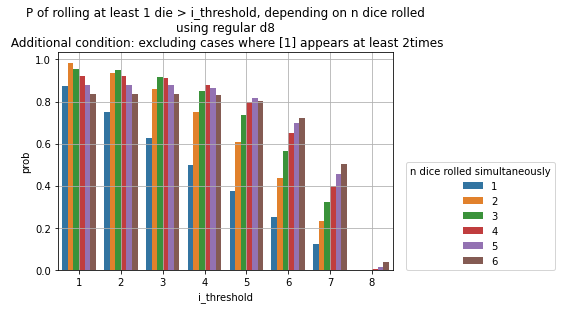

In [308]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = True,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [2,3],
                                win_number_repeated_threshold = 4,
                               plot_it = True)

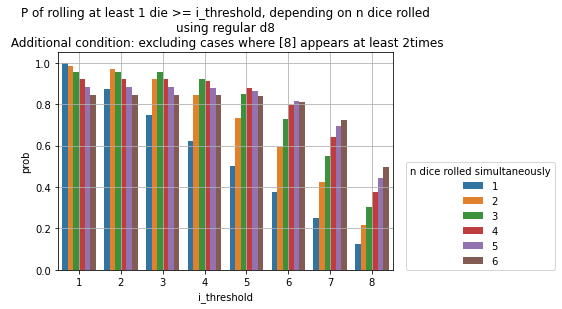

In [306]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [8],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [1,2],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

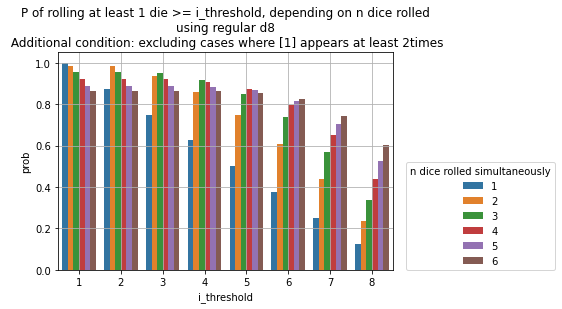

In [297]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7,8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

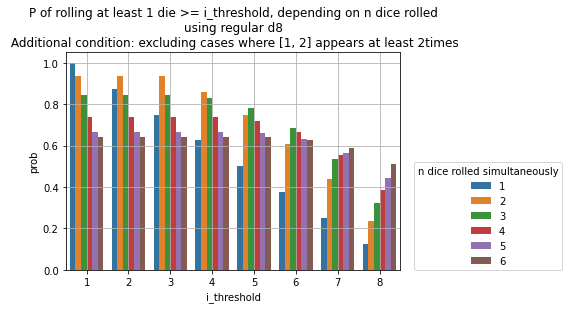

In [296]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1,2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7,8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

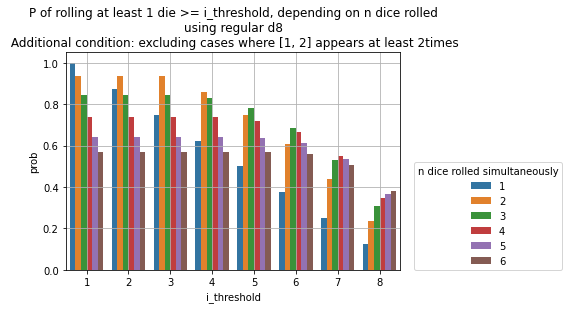

In [295]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1,2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [7,8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

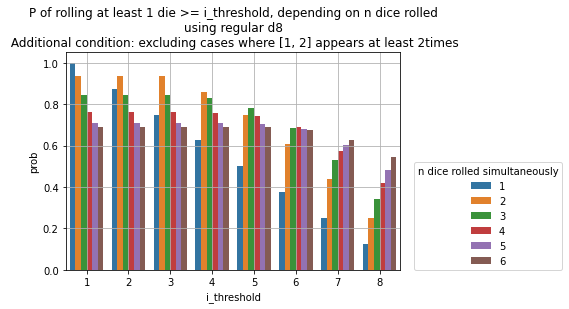

In [294]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1,2],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [7,8],
                                win_number_repeated_threshold = 2,
                               plot_it = True)

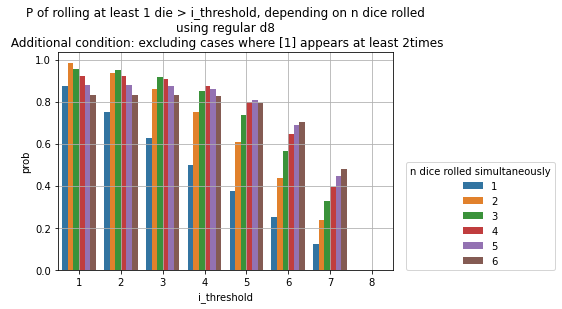

In [262]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = True,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [0],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

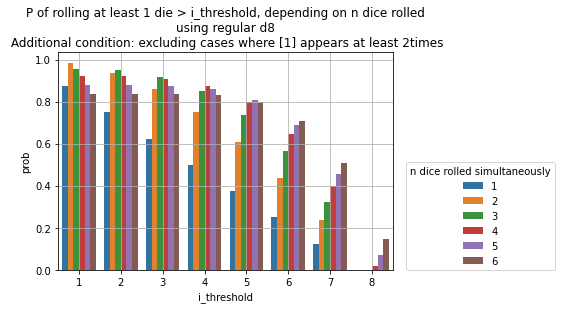

In [266]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = True,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7,8],
                                win_number_repeated_threshold = 4,
                               plot_it = True)

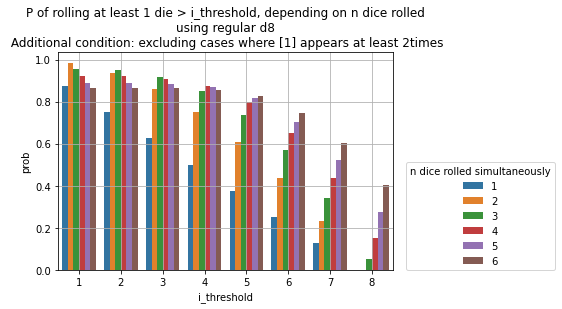

In [265]:
dice_n_faces=8
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = True,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [6,7,8],
                                win_number_repeated_threshold = 3,
                               plot_it = True)

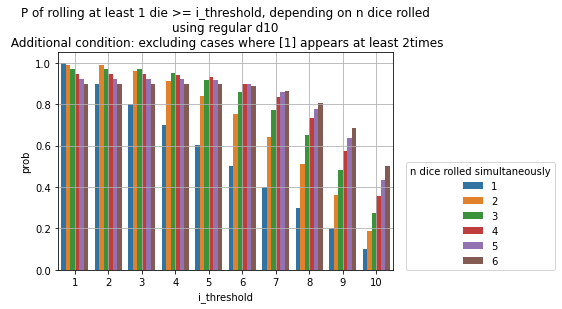

In [316]:
dice_n_faces=10
max_n_simultaneous_throws = 6


throws = simulate_dice_throws(dice_n_faces=dice_n_faces, 
                              max_n_simultaneous_throws=max_n_simultaneous_throws)

results_df = prob_at_least_X_higher_and_no_repeated(throws, 
                                dice_n_faces=dice_n_faces, 
                                max_n_simultaneous_throws=max_n_simultaneous_throws,                               
                                greater = False,
                                loss_number_repeated = [1],
                                loss_number_repeated_threshold = 2,
                                win_number_repeated = [8,9,10],
                                win_number_repeated_threshold = 3,
                               plot_it = True)